<img width="50" src="https://carbonplan-assets.s3.amazonaws.com/monogram/dark-small.png" style="margin-left:0px;margin-top:20px"/>

# MTBS Fire Model

_by Jeremy Freeman (CarbonPlan), September 19, 2020_

This notebook loads downsampled MTBS fire data and TerraClimate climate data and
fits a logistical regression model.


In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from carbonplan_forests import load, setup, plot, fit

In [2]:
setup.plotting(remote=False)

In [2]:
%load_ext autoreload
%autoreload 2

First we set some top-level parameters: the level of spatial coarsening (which
can speed up fitting substantially, especially useful when testing), the time
range (MTBS spans 1984 to 2018), and the climatic variables we'll use in the
model.


In [17]:
coarsen = 16
tlim = (1984, 2018)
data_vars = ["ppt", "tavg"]

First we load data from `nlcd` which we will use to mask out non-land areas and
data from `nftd` to use a regressors for forest type groups.


In [18]:
mask = load.nlcd(store="local", classes="all", year=2001)
groups = load.nftd(
    store="local", groups="all", coarsen=coarsen, mask=mask, area_threshold=1500
)

Now we load the `terraclim` data from the same time range.


In [5]:
climate = load.terraclim(
    store="local", tlim=tlim, coarsen=coarsen, data_vars=data_vars, mask=mask
)

And finally load the `mtbs` data, setting all non-zero values to 1 as setup for
our logistic model.


In [78]:
mtbs = load.mtbs(store="local", coarsen=0, tlim=tlim)

In [15]:
%matplotlib inline

In [7]:
from showit import image

In [54]:
from scipy.stats import binom

In [55]:
def integrated_risk(p):
    return (1 - binom.cdf(0, 100, p))

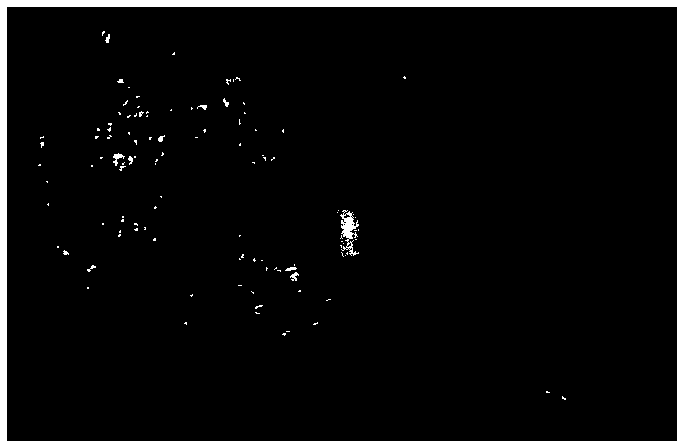

In [140]:
image(
    (
        mtbs['vlf']
        .sel(time=slice('2006', '2006'))
        .sum('time')
    ),
    size=12,
    clim=(0,1)
)

In [3]:
import rasterio

In [4]:
r = rasterio.open('/Users/freeman/workdir/carbonplan-data/processed/mtbs/conus/30m/2006.tif')

In [5]:
im = r.read(1)

In [19]:
%gui qt

In [21]:
import napari

In [23]:
napari.view_image(im==1)

/usr/local/lib/python3.8/site-packages/napari/_vispy/vispy_image_layer.py:184: UserWarning: data shape (91647, 150942) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(


### Inspecting the data


We can plot the `mtbs` data for a specific year to get a sense of the raw data.


In [15]:
plot.fire.summary(mtbs, clim=(0, 0.1))

alt.HConcatChart(...)

In [ ]:
plot.fire.monthly(mtbs.sel(time="2016"), "vlf", clim=(0, 1))

Here is the same thing but averaged over all years


In [ ]:
mtbs.groupby("time.month").mean()["vlf"].max().values

In [ ]:
plot.fire.monthly(mtbs, "vlf", clim=(0, 0.2))

We can plot spatially averaged data over time to see both seasonable trends, and
the fact that fire frequency and magnitude has increased over time.


In [ ]:
x = mtbs["time"]
y = mtbs["vlf"].mean(["x", "y"])

plot.line(
    x=x, y=y, width=900, height=200, color="rgb(175,91,92)", strokeWidth=2
)

We can summarize the data by plotting annual, seasonal, and spatial trends by
averaging across different groupings and dimensions.


In [ ]:
plot.fire.summary(mtbs, "vlf", clim=(0, 0.05))

As a motivation for fitting fires as functions of climatic variables, we can
look at spatially averaged climatic variables alongside fires, e.g. average
tempreature, and see that there is a clear relationship (in this case a positive
correlation).


In [ ]:
x = mtbs.groupby("time.year").mean()["year"]
y1 = mtbs["vlf"].groupby("time.year").mean().mean(["x", "y"])
y2 = climate["tavg"].groupby("time.year").mean().mean(["x", "y"])

(
    plot.line(x=x, y=sp.stats.zscore(y1), color="rgb(175,91,92)")
    + plot.line(x=x, y=sp.stats.zscore(y2), color="rgb(175,91,92)", opacity=0.5)
)

### Fitting the model


We'll define the variables to use in the model


In [ ]:
fit_vars = ["tavg", "ppt"]

Then we fit it by providing both the climate variables and the forest type
groups. We distinguish the two sets of input variables because the climate
variables change over time by the groups do not.


In [ ]:
model = fit.fire(x=climate[fit_vars], y=mtbs["vlf"], f=groups)

We can evaluate the fitting model on arbitrary new inputs. In this case, we
evaluate on the data we used to fit.


In [ ]:
prediction = model.predict(x=climate[fit_vars], f=groups)

We can plot the predictions monthly just as we plotted the real data.


In [ ]:
plot.fire.monthly(prediction, "prob", clim=(0, 0.01))

And we can plot the same summary of trends but now with both data and model


In [ ]:
plot.fire.evaluation(mtbs, prediction, "vlf", "prob", clim=(0.002, 0.02))

We can also compare the predicted and real probabilities over time.


In [ ]:
x = mtbs["time"]
y1 = mtbs["vlf"].mean(["x", "y"])
y2 = prediction["prob"].mean(["x", "y"])

(
    plot.line(
        x=x,
        y=y1,
        width=900,
        height=200,
        opacity=0.5,
        color="rgb(175,91,92)",
        strokeWidth=2,
    )
    + plot.line(
        x=x, y=y2, width=900, height=200, color="rgb(175,91,92)", strokeWidth=2
    )
)

Given that we fit a logistic regression, the natural model performance metric is
area under the ROC curve, which we computed on the training data (you can use
the variable `crossval` to repeat the model fit and compute a score on 25% held
out data).


In [ ]:
model.train_roc

Finally, we can compute correlations between model and prediction for annual,
seasonal, and spatial trends. Note that these were not metrics used to
explicitly fit the model, but in general a better fitting model ought to
reproduce at least some of these trends.


In [ ]:
print("correlation of annual trends")
np.corrcoef(
    mtbs["vlf"].groupby("time.year").mean().mean(["x", "y"]),
    prediction["prob"].groupby("time.year").mean().mean(["x", "y"]),
)[0, 1]

In [ ]:
print("correlation of monthly trends")
np.corrcoef(
    mtbs["vlf"].groupby("time.month").mean().mean(["x", "y"]),
    prediction["prob"].groupby("time.month").mean().mean(["x", "y"]),
)[0, 1]

In [ ]:
print("correlation of spatial trends")
np.corrcoef(
    mtbs["vlf"].mean("time").values.flatten(),
    prediction["prob"].mean("time").values.flatten(),
)[0, 1]